In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ames-data-training-and-test/test_y4.csv
/kaggle/input/ames-data-training-and-test/test10.csv
/kaggle/input/ames-data-training-and-test/train8.csv
/kaggle/input/ames-data-training-and-test/train4.csv
/kaggle/input/ames-data-training-and-test/train7.csv
/kaggle/input/ames-data-training-and-test/test6.csv
/kaggle/input/ames-data-training-and-test/test_y10.csv
/kaggle/input/ames-data-training-and-test/test_y8.csv
/kaggle/input/ames-data-training-and-test/test_y3.csv
/kaggle/input/ames-data-training-and-test/test_y6.csv
/kaggle/input/ames-data-training-and-test/train9.csv
/kaggle/input/ames-data-training-and-test/test_y2.csv
/kaggle/input/ames-data-training-and-test/test1.csv
/kaggle/input/ames-data-training-and-test/train3.csv
/kaggle/input/ames-data-training-and-test/test1_test.csv
/kaggle/input/ames-data-training-and-test/test8.csv
/kaggle/input/ames-data-training-and-test/test9.csv
/kaggle/input/ames-data-training-and-test/test5.csv
/kaggle/input/ames-data-training-and-tes

In [2]:
import numpy as np
import pandas as pd
import os
from sklearn import metrics
from sklearn import linear_model as lm
from sklearn.preprocessing import StandardScaler as SC
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from scipy.stats.mstats import winsorize
import matplotlib
import matplotlib.pyplot as plt
import time
#from xgboost import XGBRegressor
import xgboost as xgb
np.random.seed(9549)

In [3]:
#Importing Test and Training Dataset

#train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
#test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')
train = pd.read_csv('../input/ames-data-training-and-test/train1.csv')
test = pd.read_csv('../input/ames-data-training-and-test/test1.csv')
test_y = pd.read_csv('../input/ames-data-training-and-test/test_y1.csv')


#train.head()
#test.head()

In [4]:
#list(train.columns)

Finding out more about the data

In [5]:
#train.info()

Seperating target and features

In [6]:
y_train, train = train['Sale_Price'], train.drop(['Sale_Price'], axis=1)

PID_train, train = train['PID'], train.drop(['PID'], axis=1)

PID_test, test = test['PID'], test.drop(['PID'], axis=1)


In [7]:
y_train.describe()

count      2051.000000
mean     180980.317406
std       80913.184550
min       12789.000000
25%      129450.000000
50%      160000.000000
75%      212700.000000
max      755000.000000
Name: Sale_Price, dtype: float64

Finding correlation between variables

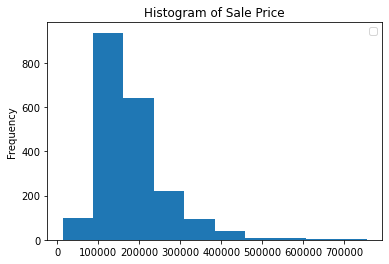

In [8]:
#plt.hist(train["Sale_Price"])
plt.hist(y_train)
plt.gca().set(title = 'Histogram of Sale Price', ylabel = 'Frequency')
plt.legend()

Based on the plot "Sale_Price" is positively skewed and has a high peak. Thus it's not a normal distribution, this can be fixed by using logarithm of the target to be used in the models.

Finding out the skewness and Kurtsois values of the target

In [9]:
print("Skewness:", y_train.skew())
print("Kurtsois:", y_train.kurt())

Skewness: 1.8116366781679032
Kurtsois: 5.470870304615207


The values confirm the histogram plot findings:
Skweness > 1 -> The distribution is highly skewed.
Kurtosis > 3 -> The distribution has a high peak and outliers are present (Leptokurtic)

Taking logarithm of the data to fix the skewness:

(array([  1.,   0.,   6.,  24., 123., 689., 754., 343.,  99.,  12.]),
 array([ 9.45641889,  9.86422444, 10.27202999, 10.67983553, 11.08764108,
        11.49544662, 11.90325217, 12.31105772, 12.71886326, 13.12666881,
        13.53447435]),
 <BarContainer object of 10 artists>)

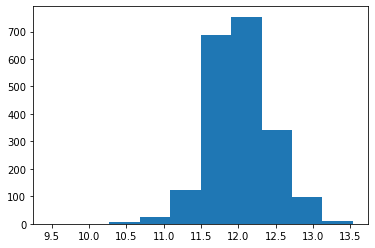

In [10]:
y_train = np.log1p(y_train)
test_y = np.log1p(test_y)
plt.hist(y_train)

Ok, now the target distribution looks like a normal distribution. Let's re-calculate skweness and kurtsois to validate the observation:

In [11]:
print("Skewness:", y_train.skew())
print("Kurtsois:", y_train.kurt())

Skewness: 0.04196882215572036
Kurtsois: 1.398590111915511


-0.5 < skewness < 0.5 -> Fairly symmetrical distribution
Kurtsois ~ 0 -> Fairly few outliers
If the skewness is between -0.5 and 0.5, the data are fairly symmetrical.

**Finding Features With Highest Correlations**

Based on personal perception, I expect features like "Overall Quality", "Neighborhood", "Lot size", "garage quality" have high correlation with the house price.
Also, some features such as "Overall Quality" and "Overall Condition" or "Garage Quality" and "Garage Condition" sound similar, so must have high correlation.
We can either plot each feature's correlation vs "Sale_Price" to find the highest correlated features, or use heatmap to find the highest correlations (correlations above > 05)

Creating a heatmap plot to find the highest correlations
(The next cell is copied from Matplotlib documantation webpage (https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html))

In [12]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-90, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

Using "heatmap" function to plot our correlation matrix.
(This next cell is modified for this dataset based on instructions on https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html)

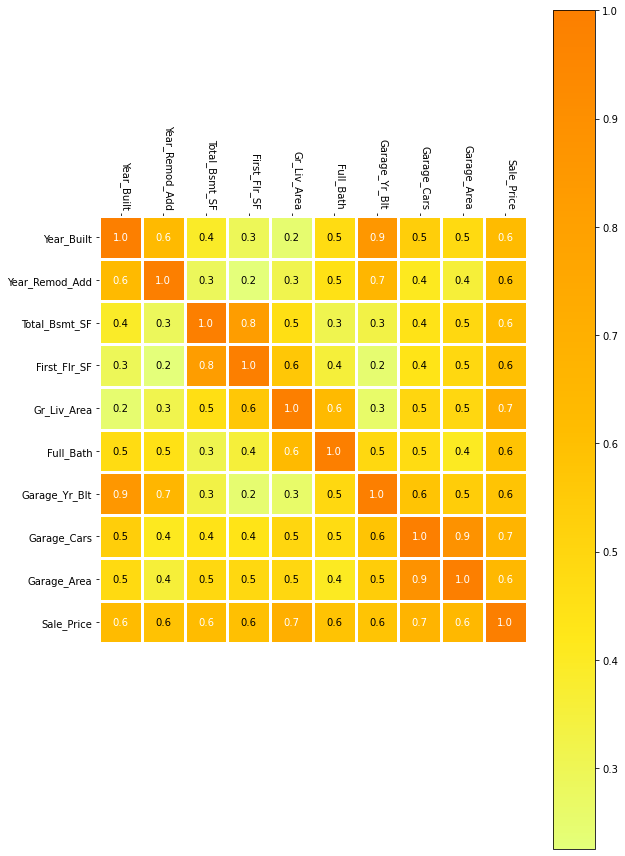

In [13]:
#new for this line
train= pd.concat([train,y_train], axis=1)
corr_matrix = train.corr()

#plt.imshow(correlation_matrix, cmap='hot', interpolation='nearest')
highest_correlations = corr_matrix.index[abs(corr_matrix["Sale_Price"])>0.5]
highest_correlations_features = list(corr_matrix.index[abs(corr_matrix["Sale_Price"])>0.5])

#print(highest_correlations)
variables = list(highest_correlations)
fig, ax = plt.subplots(figsize=(9,12))

im, cbar = heatmap(train[highest_correlations].corr(), highest_correlations, highest_correlations, ax=ax,
                   cmap="Wistia")
texts = annotate_heatmap(im, valfmt="{x:.1f}")

fig.tight_layout()
plt.show()

The correlation matrix heatmap shows below highly correlated features:
* "Overall Quality" has the highest correlation with "Sale Price" (0.8)
* "garageCars" and "GarageArea" (0.9)
* "TotalBsmtSF" and "1stFlrSF" (0.8)
* "GrLivArea" and "TotRmsAbvGrd" (0.8)

Hence, only one feature of each of the last 3 pairs should be used for developing the model. Between "GrLivArea" and "TotRmsAbvGrd" I chose to keep "GrLivArea" since has a higher correlation with "Sale Price". The other two pairs have same correlation value, so there was no preference over which one to keep. 


Then, I decided to plot correlation plots for each feature in the correlation matrix above vs. the target ("Sale Price")

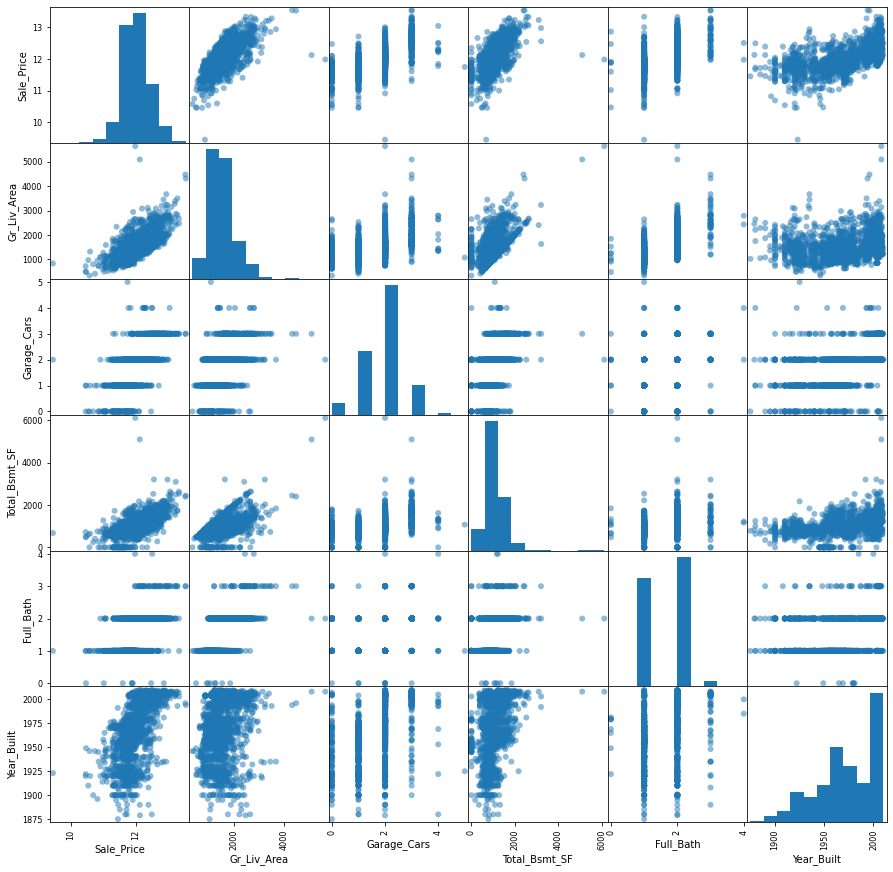

In [14]:
features = ['Sale_Price', 'Overall_Qual', 'Gr_Liv_Area', 'Garage_Cars', 'Total_Bsmt_SF', 'Full_Bath', 'Year_Built']

plots = pd.plotting.scatter_matrix(train[features], figsize=(15,15), marker = 'o')

plt.show()

Now we have a better perception of high correlated features distribution vs the target variable and the other variables.

**Handeling Missing Values**

Exploring missing values in the training data.
Some parts of the code below are used from/based on: https://www.kaggle.com/tomasmontielprieto/keeping-it-simple-eda-lasso-model-rmse-0-126

In [15]:
total_train = train.isnull().sum().sort_values(ascending = False)
percent_train = (train.isnull().sum()/train.isnull().count()).sort_values(ascending = False)
missing_training_data = pd.concat([total_train, percent_train], axis = 1, keys = ['Total', 'Percent'])
missing_training_data.head(20)

,Total,Percent
Garage_Yr_Blt,102,0.049732
MS_SubClass,0,0.000000
Garage_Area,0,0.000000
Garage_Finish,0,0.000000
Garage_Type,0,0.000000
Fireplace_Qu,0,0.000000
Fireplaces,0,0.000000
Functional,0,0.000000
TotRms_AbvGrd,0,0.000000
Kitchen_Qual,0,0.000000


In [16]:
total_test = test.isnull().sum().sort_values(ascending=False)
percentage_test = (test.isnull().sum()/test.isnull().count()).sort_values(ascending=False)
missing_test_data = pd.concat([total_test, percentage_test], axis=1, keys=['Total', 'Percent'])
missing_test_data.head(20)

,Total,Percent
Garage_Yr_Blt,57,0.064846
MS_SubClass,0,0.000000
Electrical,0,0.000000
Garage_Finish,0,0.000000
Garage_Type,0,0.000000
Fireplace_Qu,0,0.000000
Fireplaces,0,0.000000
Functional,0,0.000000
TotRms_AbvGrd,0,0.000000
Kitchen_Qual,0,0.000000


**Filling Out Missing Values for Numerical Features**

Missing values for numerical features are replaced with zero becauce (Refer to Dr's Piazza post why). The only feature with missing values is 'Garage_Yr_blt"

In [17]:
numerical_features = ['Garage_Yr_Blt']

#Feeling out numerical missing values for training set
for feature in numerical_features:
    train[feature] = train[feature].fillna(0)

#Feeling out numerical missing values for test set
for feature in numerical_features:
    test[feature] = test[feature].fillna(0)

Let's check if we have addressed all the missing values for the numerical features.

In [18]:
check_missing_train = train[numerical_features].isnull().sum().sort_values(ascending = False)
check_missing_train.head(20)

Garage_Yr_Blt    0
dtype: int64

Now that we do not have missing values in our data, let us see if there are other numberical features that are skewed. 
It is important for our data to be close to a normal distribution as our models assume normal distribution.

In [19]:
#Finding Numerical Features

numerical = train.dtypes[train.dtypes != 'object'].index

highly_skewed =  numerical[np.abs(train[numerical].skew()) > 0.5]


print("Skewness:", train[highly_skewed].skew())
print("Kurtsois:", train[highly_skewed].kurt())

Skewness: Lot_Area              10.336851
Year_Built            -0.603963
Mas_Vnr_Area           2.428758
BsmtFin_SF_2           4.265256
Bsmt_Unf_SF            0.925847
Total_Bsmt_SF          1.445360
First_Flr_SF           1.574626
Second_Flr_SF          0.823556
Low_Qual_Fin_SF       13.529257
Gr_Liv_Area            1.305284
Bsmt_Full_Bath         0.635260
Bsmt_Half_Bath         3.895176
Half_Bath              0.693623
Kitchen_AbvGr          4.401753
TotRms_AbvGrd          0.746795
Fireplaces             0.762775
Garage_Yr_Blt         -4.121952
Wood_Deck_SF           2.037472
Open_Porch_SF          2.692091
Enclosed_Porch         4.113688
Three_season_porch    12.619464
Screen_Porch           3.876751
Pool_Area             16.311768
Misc_Val              18.511646
Latitude              -0.510526
dtype: float64
Kurtsois: Lot_Area              173.714538
Year_Built             -0.491246
Mas_Vnr_Area            7.476179
BsmtFin_SF_2           20.188047
Bsmt_Unf_SF             0.392391


Next, we transform these highly skewed features to normal distribution with taking their natural logarithm.

In [20]:
train[highly_skewed] = np.log1p(train[highly_skewed])

test[highly_skewed] = np.log1p(test[highly_skewed])

**New Column: Total Area**

Based on personal experience and exploring Zillow and Redfin listings, total area of the house is an essential feature and the variable used to find price/sf. This dataset has individual areas per floors, yet not the total area. Below we add this columns using the individual area measures.

In [21]:
train['total_area'] = train['Total_Bsmt_SF'] + train['First_Flr_SF'] + train['Second_Flr_SF']

test['total_area'] = test['Total_Bsmt_SF'] + test['First_Flr_SF'] + test['Second_Flr_SF']

Now let's drop the unimportant features:

In [22]:
train.drop('Garage_Cars', axis=1, inplace=True)
test.drop('Garage_Cars', axis=1, inplace=True)

train.drop('Total_Bsmt_SF', axis=1, inplace=True)
test.drop('Total_Bsmt_SF', axis=1, inplace=True)

train.drop('TotRms_AbvGrd', axis=1, inplace=True)
test.drop('TotRms_AbvGrd', axis=1, inplace=True)



Winsorizing the numerical features with outliers

In [23]:
#winsorize(train["Lot_Frontage"], limits=[0, 0.95], inplace = True)
#winsorize(test["Lot_Frontage"], limits=[0, 0.95], inplace = True)

#winsorize(train["Lot_Area"], limits=[0, 0.95], inplace = True)
#winsorize(test["Lot_Area"], limits=[0, 0.95], inplace = True)

#winsorize(train["Mas_Vnr_Area"], limits=[0, 0.95], inplace = True)
#winsorize(test["Mas_Vnr_Area"], limits=[0, 0.95], inplace = True)

#winsorize(train["BsmtFin_SF_2"], limits=[0, 0.95], inplace = True)
#winsorize(test["BsmtFin_SF_2"], limits=[0, 0.95], inplace = True)

#winsorize(train["Bsmt_Unf_SF"], limits=[0, 0.95], inplace = True)
#winsorize(test["Bsmt_Unf_SF"], limits=[0, 0.95], inplace = True)

#winsorize(train["Second_Flr_SF"], limits=[0, 0.95], inplace = True)
#winsorize(test["Second_Flr_SF"], limits=[0, 0.95], inplace = True)

#winsorize(train["First_Flr_SF"], limits=[0, 0.95], inplace = True)
#winsorize(test["First_Flr_SF"], limits=[0, 0.95], inplace = True)

#winsorize(train["Gr_Liv_Area"], limits=[0, 0.95], inplace = True)
#winsorize(test["Gr_Liv_Area"], limits=[0, 0.95], inplace = True)

#winsorize(train["Wood_Deck_SF"], limits=[0, 0.95], inplace = True)
#winsorize(test["Wood_Deck_SF"], limits=[0, 0.95], inplace = True)

#winsorize(train["Open_Porch_SF"], limits=[0, 0.95], inplace = True)
#winsorize(test["Open_Porch_SF"], limits=[0, 0.95], inplace = True)

#winsorize(train["Enclosed_Porch"], limits=[0, 0.95], inplace = True)
#winsorize(test["Enclosed_Porch"], limits=[0, 0.95], inplace = True)

#winsorize(train["Three_season_porch"], limits=[0, 0.95], inplace = True)
#winsorize(test["Three_season_porch"], limits=[0, 0.95], inplace = True)

#winsorize(train["Screen_Porch"], limits=[0, 0.95], inplace = True)
#winsorize(test["Screen_Porch"], limits=[0, 0.95], inplace = True)

#winsorize(train["Misc_Val"], limits=[0, 0.95], inplace = True)
#winsorize(test["Misc_Val"], limits=[0, 0.95], inplace = True)

The last step in preparing our data is to convert the categorical variables to numerical with creating dummy variables. This step is necessary as our models work with numerical values.

In [24]:
x_train = train.loc[:, train.columns != 'Sale_Price']

y_train = train['Sale_Price']

#Prepare train and test data for modelling


print("before:")
print("train: ", x_train.shape)
print("Test: ", test.shape)


x_train = pd.get_dummies(x_train)
test = pd.get_dummies(test)


print("after:")
print("train: ", x_train.shape)
print("Test: ", test.shape)

before:
train:  (2051, 79)
Test:  (879, 79)
after:
train:  (2051, 344)
Test:  (879, 322)


Creating dummy missing columns in test dataset based on training dataset and filling them out with zero

In [25]:
# Get missing columns in the training test
missing_cols = set( x_train.columns ) - set( test.columns )
# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    test[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
test = test[x_train.columns]

In [26]:
print("train: ", x_train.shape)
print("Test: ", test.shape)

train:  (2051, 344)
Test:  (879, 344)


# **APPLYING MODELS**

Preparing data for our models

# Gradient Boost Model

In [27]:
start_time_xgb = time.time()
xgb_model = xgb.XGBRegressor(verbosity = 0, gamma=0.025, colsample_bytree=0.42,
                             learning_rate=0.005, max_depth=6,
                             n_estimators=3800,
                             reg_alpha=0.1, reg_lambda=0.95,
                             subsample=0.55, random_state =9549)
xgb_model.fit(x_train, y_train)

print("Time:", time.time() - start_time_xgb)

Time: 30.82521963119507


Predicting our first set of data

In [28]:
y_predict_xgb = np.floor(np.expm1(xgb_model.predict(test)))
#y_predict = xgb_model.predict(test)

In [30]:
PID_test = [(str(x)+ ",") for x in PID_test]
output_xgb = pd.DataFrame({'PID': PID_test, 'Sale_Price': y_predict_xgb})
output_xgb

,PID,Sale_Price
0,909101010,133929.0
1,903458170,102811.0
2,527110120,179036.0
3,535457090,141524.0
4,904100020,112958.0
...,...,...
874,527354050,178998.0
875,908152270,155585.0
876,528429110,246477.0
877,533212010,151252.0


In [31]:
y_predict_xgb = y_predict_xgb.reshape(-1,1)

RMSE = np.sqrt(np.mean((np.log1p(y_predict_xgb) - test_y) ** 2))
print(RMSE)


Sale_Price    0.12316
dtype: float64


# Linear Regression

For linear regression models such as Lasso it is essential to have the data scaled, since these models are very sensetive to feature weights

In [32]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(test)

**Choosing Alpha**

Alpha is the parameter to control how much regularization we want on our model. To find out the best alpha in terms of the least RMSE, we will use GridSearchCV to find the best Alpha value.
(To find the best alpha value, after several rounds of try and error by hand, I found this part of code in Kaggle which was very useful. Source: https://www.kaggle.com/tomasmontielprieto/keeping-it-simple-eda-lasso-model-rmse-0-126)

In [33]:
las = Lasso()
grid_values = {'alpha': [0.0001,0.0002,0.00025, 0.0003, 0.00036, 0.00037, 0.000375, 0.00038, 0.00039,0.000395, 0.0004,0.00045,0.00047, 0.0005,0.00051, 0.00052, 0.00055, 0.0006,0.0008,0.001,0.01, 0.02]}
grid_las_mse = GridSearchCV(las, param_grid = grid_values, scoring = 'neg_mean_squared_error',n_jobs = -1)
grid_las_mse.fit(x_train_scaled, y_train)
print('Grid best parameter (min. mse): ', grid_las_mse.best_params_)

Grid best parameter (min. mse):  {'alpha': 0.00038}


Now we use the best found alpha value in our model to build the model with our training data and predict results

In [34]:
start_time_lasso = time.time()
las = Lasso( alpha = 0.00038, random_state = 9549).fit(x_train_scaled,y_train)
print('Accuracy on train data: {:.2f}'.format(las.score(x_train_scaled,y_train)))
print('Accuracy on test data: {:.2f}'.format(las.score(x_test_scaled,test_y)))
y_predict_las = np.expm1(las.predict(x_test_scaled))
#print(y_predict_las)

print("Time:", time.time() - start_time_lasso)

mean_squared_error(test_y, las.predict(x_test_scaled), squared=False)

Accuracy on train data: 0.93
Accuracy on test data: 0.90
Time: 0.12267637252807617


0.12587550220324795

For the last step we are going to record the prediction results and save them in a csv file.

In [35]:
output_lasso = pd.DataFrame({'PID': PID_test, 'Sale_Price': y_predict_las})
output_lasso

,PID,Sale_Price
0,909101010,130519.206983
1,903458170,105756.676555
2,527110120,179479.165518
3,535457090,143907.753111
4,904100020,109677.113429
...,...,...
874,527354050,185921.668053
875,908152270,146215.845650
876,528429110,268072.708283
877,533212010,152506.090486


In [36]:
#f=open('mysubmission2.txt','a')
#np.savetxt(f, output_xgb,delimiter=" ", fmt="%s")
#f.write("\n")
#f.close()

f = open("mysubmission2.txt", "w")
f.write('PID,\t Sale_Price')
f.write("\n")
for id, row in output_xgb.iterrows():
    f.write(str(row['PID']))
    f.write(",")
    f.write(str(row['Sale_Price']))
    #f.write(row)
    f.write("\n")
f.close()


f = open("mysubmission1.txt", "w")
f.write('PID,\t Sale_Price')
f.write("\n")
for id, row in output_lasso.iterrows():
    f.write(str(row['PID']))
    f.write(",")
    f.write(str(row['Sale_Price']))
    #f.write(row)
    f.write("\n")
f.close()


#output_xgb.to_csv('mysubmission2.txt', header=True, index=None, sep=',')
#np.savetxt('mysubmission2.txt', output_xgb.values, delimiter=",", header="PID,\tSale_Price", fmt="%s")
#np.savetxt('mysubmission1.txt', output_lasso.values, delimiter=",", header = "PID,\tSale_Price", fmt="%s")
#num.savetxt('test.txt', DAT, delimiter=" ", fmt="%s") 

In [37]:
#f=open('mysubmission1.txt')
#np.savetxt(f, output_lasso,delimiter=" ", fmt="%s")
#f.write("\n")
#f.close()